In [56]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import operating_points as op
import env

In [57]:
print(op.__file__)
print(dir(op))

c:\Users\bevan\OneDrive - Institut Teknologi Bandung\TESIS\ModelBaruRaybe\pyEnvironment\operating_points.py
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'math', 'steadycruise25', 'steadyhover0']


In [58]:
force_history = []
params = {'c': 0.263,  # MAC
          'S': 0.441,  # Reference Area
          'g': 9.81,  # gravity
          'm': 4.5,  # Raybe Mass
          'Iyy': 0.13,  # Raybe Inertia
          'w1': 6.0,  # Flexible Mode 1 Nat.Freq in rad/s
          'rho': 1.225,
          'R_aft': 0.5,  # meters, moment arm motor aft
          'R_fwd': 0.15,  # meters, moment arm motor fwd
          }

In [59]:
raybe_eom = env.raybe_eom

In [60]:
x0,inp0 = op.steadycruise25()

In [61]:
print(inp0)

(5.5215, 0, 0.68849, -0.058089)


In [62]:
dt=0.1
t_start = 0.0
t_end = 100
# time grid where you want the solution
t_grid = np.arange(t_start, t_end + dt, dt)

In [63]:
T_fwd = np.zeros_like(t_grid)
T_fwd[0:1002] = inp0[0]

Tilt_rate = np.zeros_like(t_grid)
T_aft = np.zeros_like(t_grid)
T_aft[0:1002] = inp0[2]
elevator = np.zeros_like(t_grid)
elevator[0:1002] = inp0[3]

def input(k):
    inp = (T_fwd[k],Tilt_rate[k],T_aft[k],elevator[k])
    return inp

In [64]:
x_hist = np.zeros((len(x0), len(t_grid)))
x_hist[:, 0] = x0
x_hist[:, 0]
t_grid

array([  0. ,   0.1,   0.2, ...,  99.8,  99.9, 100. ], shape=(1001,))

In [68]:
# allocate storage for solution (assuming x0 is 1D array)
x_hist = np.zeros((len(x0), len(t_grid)))
x_hist[:, 0] = x0

for k in range(1, len(t_grid)):
    t0 = t_grid[k-1]
    t1 = t_grid[k]

    sol = solve_ivp(
        raybe_eom,
        (t0, t1),
        x_hist[:, k-1],          # previous state as new IC
        method='RK45',
        args=(params, input(k),),
        t_eval=[t1],             # solution only at t1
        rtol=1e-5,
        atol=1e-5,
        dense_output=True
    )
    # take the state at t1 (only one column because t_eval has length 1)
    x_hist[:, k] = sol.y[:, 0]

x_hist.shape = (9, 1001)


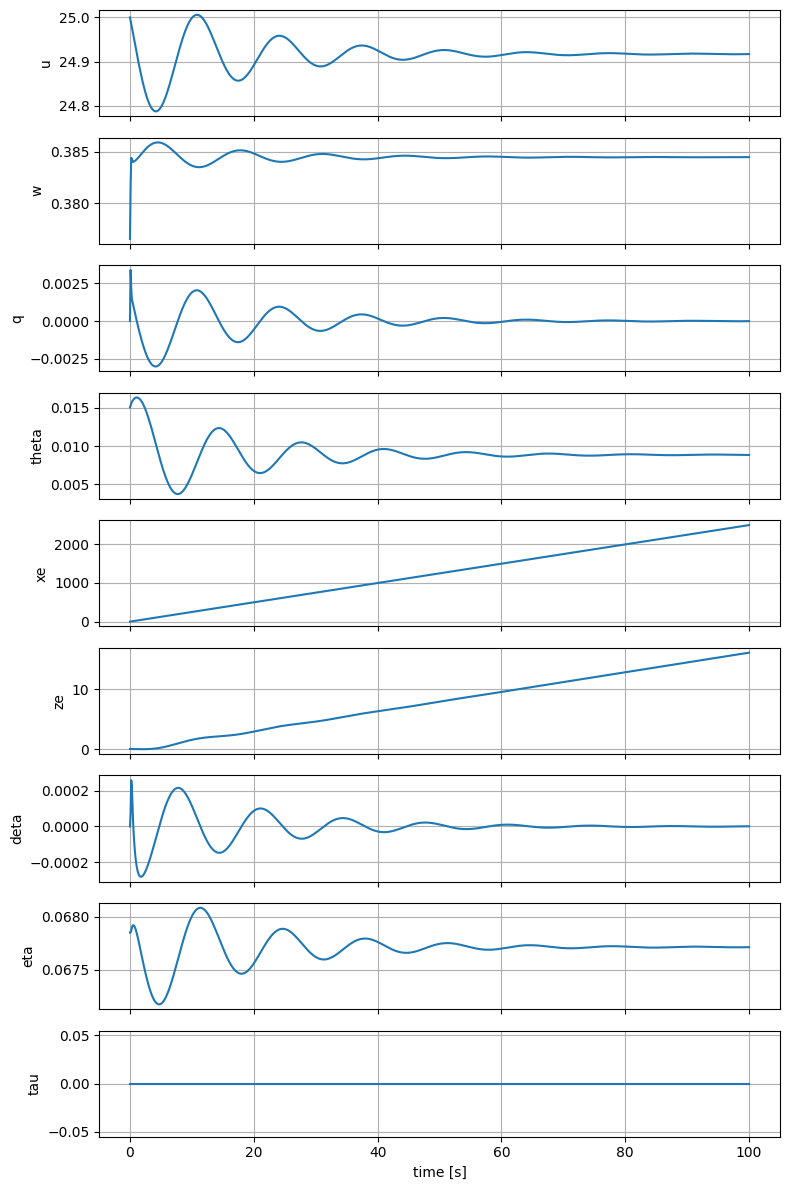

In [66]:
state_names = ["u", "w", "q", "theta", "xe", "ze", "deta", "eta", "tau"]

print("x_hist.shape =", x_hist.shape)  # should be (9, len(t_grid))

assert x_hist.ndim == 2, "x_hist must be 2D (n_states, n_time)"
assert x_hist.shape[0] == len(state_names), "len(state_names) must equal x_hist.shape[0]"
assert x_hist.shape[1] == len(t_grid), "len(t_grid) must equal x_hist.shape[1]"

fig, axes = plt.subplots(len(state_names), 1, figsize=(8, 12), sharex=True)

# if len(state_names) == 1, axes is not an array; normalize
if len(state_names) == 1:
    axes = [axes]

for i, name in enumerate(state_names):
    axes[i].plot(t_grid, x_hist[i, :])
    axes[i].set_ylabel(name)
    axes[i].grid(True)

axes[-1].set_xlabel("time [s]")
fig.tight_layout()
plt.show()
